# DIFrauD Multilingual Data Quality Assessment
## Analyzing Language Diversity Impact on Classification Performance

**Course:** COSC 4371 Security Analytics - Fall 2025  
**Team Members:** Joseph Mascardo, Niket Gupta  

---

### Project Objective
Investigate whether all samples in the DIFrauD dataset are in English, analyze language distribution by class and domain, and study the impact on classification performance.

### Research Questions
1. What is the language distribution across classes and domains in DIFrauD?
2. How does removing non-English samples affect classifier performance?
3. Do transformer-based models handle multilingual content better than traditional ML?

---

## External Sources and References

### Dataset
- **DIFrauD Dataset**: https://huggingface.co/datasets/difraud/difraud
- **Citation**: Boumber, D., et al. (2024). "Domain-Agnostic Adapter Architecture for Deception Detection." LREC-COLING 2024.

### Libraries Used
- **langdetect**: https://pypi.org/project/langdetect/ - Language detection (port of Google's language-detection)
- **datasets**: https://huggingface.co/docs/datasets/ - HuggingFace datasets library
- **transformers**: https://huggingface.co/docs/transformers/ - HuggingFace transformers for DistilBERT
- **scikit-learn**: https://scikit-learn.org/ - Traditional ML classifiers
- **pandas/numpy**: Data processing
- **matplotlib/seaborn**: Visualizations

### Key References
- Conneau, A., et al. (2020). "Unsupervised cross-lingual representation learning at scale." ACL 2020.
- Devlin, J., et al. (2019). "BERT: Pre-training of deep bidirectional transformers." NAACL 2019.
- Verma, R. M., et al. (2019). "Data quality for security challenges." ACM CCS 2019.

---
## 1. Environment Setup and Imports

**Steps taken:**
1. Install required packages
2. Import necessary libraries
3. Set random seeds for reproducibility

In [1]:
# Install required packages (run once)
# Source: Standard pip installation
!pip install -q datasets langdetect transformers torch scikit-learn pandas numpy matplotlib seaborn tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:

# Import libraries
import os
import warnings
from getpass import getpass
warnings.filterwarnings('ignore')

# Data handling
import pandas as pd
import numpy as np
from collections import Counter, defaultdict

# Dataset loading - Source: https://huggingface.co/docs/datasets/
from datasets import load_dataset, concatenate_datasets

# Language detection - Source: https://pypi.org/project/langdetect/
from langdetect import detect, detect_langs, LangDetectException

# ML libraries - Source: https://scikit-learn.org/
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_score, recall_score, accuracy_score,
    balanced_accuracy_score
)
from sklearn.preprocessing import LabelEncoder

# Deep Learning - Source: https://huggingface.co/docs/transformers/
import torch
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback
)

# Experiment tracking
import wandb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Translation
from transformers import pipeline, AutoModelForSeq2SeqLM, AutoTokenizer

# Progress tracking
from tqdm import tqdm

# Statistical testing
from scipy import stats

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Matplotlib style for cleaner figures
plt.style.use('seaborn-v0_8-whitegrid')

# -----------------------------------------------------------------------------
# Weights & Biases setup (optional)
# Enable by setting environment variable ENABLE_WANDB=true before running
# -----------------------------------------------------------------------------
WANDB_ENABLED = os.getenv("ENABLE_WANDB", "false").lower() == "true"
WANDB_PROJECT = os.getenv("WANDB_PROJECT", "difraud-language-analysis")
WANDB_ENTITY = os.getenv("WANDB_ENTITY")
wandb_run = None


def prompt_wandb_login():
    """Prompt the user for a W&B API key when logging is enabled.

    This keeps the workflow interactive without forcing authentication when
    ENABLE_WANDB is false. If the WANDB_API_KEY environment variable is set,
    the login uses that value automatically.
    """

    if not WANDB_ENABLED:
        print("Weights & Biases logging is disabled. Set ENABLE_WANDB=true to enable.")
        return None

    print("
Weights & Biases logging is enabled.
- Set WANDB_API_KEY env var, or paste it when prompted.")

    api_key = os.getenv("WANDB_API_KEY")
    if api_key:
        wandb.login(key=api_key)
    else:
        api_key = getpass("Enter your W&B API key (input hidden): ")
        wandb.login(key=api_key)

    run = wandb.init(project=WANDB_PROJECT, entity=WANDB_ENTITY, reinit=True)
    print(f"Initialized W&B run: {run.name}")
    return run


def log_figure(fig, name):
    """Log a matplotlib figure to Weights & Biases when enabled."""
    if wandb_run is not None:
        wandb_run.log({name: wandb.Image(fig)})


print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")



All libraries imported successfully!
PyTorch version: 2.9.0+cu126
CUDA available: True


In [ ]:
# Additional NLP + timing utilities
import spacy
from spacy.language import Language
from spacy.tokens import Doc
from time import perf_counter


---
## 2. Load DIFrauD Dataset

**Steps taken:**
1. Load all 7 domains from HuggingFace
2. Combine train, validation, and test splits
3. Create unified DataFrame with domain labels

**Dataset Source:** https://huggingface.co/datasets/difraud/difraud

In [3]:
# Define all domains in DIFrauD dataset
DOMAINS = [
    'fake_news',
    'job_scams',
    'phishing',
    'political_statements',
    'product_reviews',
    'sms',
    'twitter_rumours'
]

def load_difraud_dataset():
    """
    Load all domains from DIFrauD dataset by directly reading JSONL files.
    Source: HuggingFace datasets library
    Dataset: https://huggingface.co/datasets/difraud/difraud

    Note: The dataset uses legacy loading scripts no longer supported by datasets library,
    so we load directly from the JSONL files using data_files parameter.
    """
    all_data = []

    for domain in tqdm(DOMAINS, desc="Loading domains"):
        try:
            # Load directly from JSONL files using data_files parameter
            # This bypasses the deprecated loading script
            base_url = f"https://huggingface.co/datasets/difraud/difraud/resolve/main/{domain}"

            dataset = load_dataset(
                'json',
                data_files={
                    'train': f"{base_url}/train.jsonl",
                    'validation': f"{base_url}/validation.jsonl",
                    'test': f"{base_url}/test.jsonl"
                }
            )

            # Combine all splits
            for split in ['train', 'validation', 'test']:
                if split in dataset:
                    df_split = dataset[split].to_pandas()
                    df_split['domain'] = domain
                    df_split['split'] = split
                    all_data.append(df_split)

        except Exception as e:
            print(f"Error loading {domain}: {e}")

    # Combine all data
    if len(all_data) == 0:
        raise ValueError("No data was loaded. Check dataset availability and internet connection.")

    df = pd.concat(all_data, ignore_index=True)
    return df

# Load the dataset
print("Loading DIFrauD dataset from HuggingFace...")
print("(Downloading JSONL files directly - this may take a few minutes)\n")
df = load_difraud_dataset()

print(f"\nDataset loaded successfully!")
print(f"Total samples: {len(df):,}")
print(f"Columns: {df.columns.tolist()}")

Loading DIFrauD dataset from HuggingFace...
(Downloading JSONL files directly - this may take a few minutes)



Loading domains:   0%|          | 0/7 [00:00<?, ?it/s]

fake_news/train.jsonl:   0%|          | 0.00/55.8M [00:00<?, ?B/s]

validation.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Loading domains:  14%|█▍        | 1/7 [00:03<00:19,  3.24s/it]

job_scams/train.jsonl:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

validation.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Loading domains:  29%|██▊       | 2/7 [00:04<00:10,  2.12s/it]

phishing/train.jsonl:   0%|          | 0.00/28.3M [00:00<?, ?B/s]

validation.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Loading domains:  43%|████▎     | 3/7 [00:05<00:06,  1.73s/it]

train.jsonl: 0.00B [00:00, ?B/s]

validation.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Loading domains:  57%|█████▋    | 4/7 [00:06<00:03,  1.32s/it]

train.jsonl: 0.00B [00:00, ?B/s]

validation.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Loading domains:  71%|███████▏  | 5/7 [00:07<00:02,  1.16s/it]

train.jsonl: 0.00B [00:00, ?B/s]

validation.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Loading domains:  86%|████████▌ | 6/7 [00:08<00:00,  1.01it/s]

train.jsonl: 0.00B [00:00, ?B/s]

validation.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Loading domains: 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


Dataset loaded successfully!
Total samples: 95,854
Columns: ['text', 'label', 'domain', 'split']


In [4]:
# Dataset overview
print("="*60)
print("DATASET OVERVIEW")
print("="*60)

print("\n--- Samples by Domain ---")
domain_counts = df.groupby('domain').agg({
    'text': 'count',
    'label': ['sum', 'mean']
}).round(3)
domain_counts.columns = ['Total', 'Deceptive', 'Deceptive_Ratio']
domain_counts['Non-Deceptive'] = domain_counts['Total'] - domain_counts['Deceptive']
print(domain_counts)

print("\n--- Overall Class Distribution ---")
print(f"Deceptive (label=1): {df['label'].sum():,} ({df['label'].mean()*100:.2f}%)")
print(f"Non-Deceptive (label=0): {(df['label']==0).sum():,} ({(1-df['label'].mean())*100:.2f}%)")

print("\n--- Sample Text Lengths ---")
df['text_length'] = df['text'].str.len()
print(df.groupby('domain')['text_length'].describe().round(1))

DATASET OVERVIEW

--- Samples by Domain ---
                      Total  Deceptive  Deceptive_Ratio  Non-Deceptive
domain                                                                
fake_news             20456       8832            0.432          11624
job_scams             14295        599            0.042          13696
phishing              15272       6074            0.398           9198
political_statements  12497       8042            0.644           4455
product_reviews       20971      10492            0.500          10479
sms                    6574       1274            0.194           5300
twitter_rumours        5789       1969            0.340           3820

--- Overall Class Distribution ---
Deceptive (label=1): 37,282 (38.89%)
Non-Deceptive (label=0): 58,572 (61.11%)

--- Sample Text Lengths ---
                        count    mean     std   min     25%     50%     75%  \
domain                                                                        
fake_news       

## 2.5 Synthetic Multilingual Dataset Generation

This section builds a multilingual extension of DIFrauD with controlled language ratios, translation metadata, and validation utilities. We target 60% non-English content by translating English samples using HuggingFace Helsinki-NLP models while preserving domain and label balance.


In [ ]:
# Synthetic multilingual dataset generation helpers
TRANSLATION_PLAN = {
    'es': 0.20,  # Spanish
    'fr': 0.15,  # French
    'de': 0.10,  # German
    'pt': 0.08,  # Portuguese
    'ar': 0.05,  # Arabic
    'zh': 0.02   # Chinese
}

TRANSLATION_MODELS = {
    'es': 'Helsinki-NLP/opus-mt-en-es',
    'fr': 'Helsinki-NLP/opus-mt-en-fr',
    'de': 'Helsinki-NLP/opus-mt-en-de',
    'pt': 'Helsinki-NLP/opus-mt-en-pt',
    'ar': 'Helsinki-NLP/opus-mt-en-ar',
    'zh': 'Helsinki-NLP/opus-mt-en-zh'
}

TARGET_NON_ENGLISH_RATIO = 0.60
TRANSLATION_PIPELINES = {}

def get_translation_pipeline(target_lang):
    # Cache and return translation pipeline for target language.
    if target_lang not in TRANSLATION_MODELS:
        raise ValueError(f"Unsupported target language: {target_lang}")
    if target_lang not in TRANSLATION_PIPELINES:
        model_name = TRANSLATION_MODELS[target_lang]
        TRANSLATION_PIPELINES[target_lang] = pipeline('translation', model=model_name, tokenizer=model_name)
    return TRANSLATION_PIPELINES[target_lang]

def stratified_sample(df, sample_size, random_state=SEED):
    # Create a stratified sample by domain and label.
    if sample_size >= len(df):
        return df.sample(frac=1, random_state=random_state)
    stratify_col = df['domain'].astype(str) + '__' + df['label'].astype(str)
    sample_df, _ = train_test_split(
        df, train_size=sample_size, stratify=stratify_col, random_state=random_state
    )
    return sample_df

def translate_batch(texts, target_lang):
    translator = get_translation_pipeline(target_lang)
    outputs = translator(list(texts), max_length=512)
    return [o['translation_text'] for o in outputs]


In [ ]:
def build_synthetic_multilingual_dataset(df, target_non_english_ratio=TARGET_NON_ENGLISH_RATIO, translation_plan=TRANSLATION_PLAN, random_state=SEED):
    # Generate translated samples while maintaining domain/label balance.
    synthetic_size = len(df)
    non_english_target = int(synthetic_size * target_non_english_ratio)
    english_target = synthetic_size - non_english_target

    allocation = {k: int(v * non_english_target) for k, v in translation_plan.items()}
    allocated = sum(allocation.values())
    if allocated < non_english_target:
        top_lang = max(translation_plan, key=translation_plan.get)
        allocation[top_lang] += (non_english_target - allocated)

    df_original = df.copy()
    df_original['data_source'] = 'original'
    df_original['is_translated'] = False
    df_original['source_language'] = 'en'
    df_original['target_language'] = 'en'
    df_original['source_text'] = df_original['text']
    df_original['dataset_version'] = 'original'

    pool = df.copy().sample(frac=1, random_state=random_state).reset_index(drop=True)
    translated_frames = []
    cursor = 0

    for lang, count in allocation.items():
        subset = pool.iloc[cursor:cursor + count]
        if len(subset) < count:
            extra = stratified_sample(df, count - len(subset), random_state=random_state + hash(lang) % 1000)
            subset = pd.concat([subset, extra], ignore_index=True)
        cursor += count
        print(f"Translating {len(subset)} samples to {lang}...")
        translated_texts = translate_batch(subset['text'].tolist(), lang)
        translated_df = subset.copy()
        translated_df['source_text'] = subset['text'].values
        translated_df['text'] = translated_texts
        translated_df['data_source'] = 'synthetic'
        translated_df['is_translated'] = True
        translated_df['source_language'] = 'en'
        translated_df['target_language'] = lang
        translated_df['dataset_version'] = 'synthetic_multilingual'
        translated_frames.append(translated_df)

    translated_block = pd.concat(translated_frames, ignore_index=True)
    remaining_pool = df[~df.index.isin(translated_block.index)] if len(df) > len(translated_block) else df
    english_fallback = stratified_sample(remaining_pool, english_target, random_state=random_state)
    english_fallback = english_fallback.copy()
    english_fallback['source_text'] = english_fallback['text']
    english_fallback['data_source'] = 'synthetic'
    english_fallback['is_translated'] = False
    english_fallback['source_language'] = 'en'
    english_fallback['target_language'] = 'en'
    english_fallback['dataset_version'] = 'synthetic_multilingual'

    df_synthetic = pd.concat([translated_block, english_fallback], ignore_index=True)
    df_combined = pd.concat([df_original, df_synthetic], ignore_index=True)
    return df_original.reset_index(drop=True), df_synthetic.reset_index(drop=True), df_combined.reset_index(drop=True)

df_original, df_synthetic, df_combined = build_synthetic_multilingual_dataset(df)

print("Original dataset with metadata:", df_original.shape)
print("Synthetic multilingual dataset:", df_synthetic.shape)
print("Combined dataset:", df_combined.shape)

DATASET_REGISTRY = {
    'Original': df_original,
    'Synthetic Multilingual': df_synthetic,
    'Combined': df_combined
}

df_original.to_csv('difraud_original.csv', index=False)
df_synthetic.to_csv('difraud_synthetic_multilingual.csv', index=False)
df_combined.to_csv('difraud_combined.csv', index=False)
print("Saved difraud_original.csv, difraud_synthetic_multilingual.csv, and difraud_combined.csv")


In [ ]:
def validate_synthetic_dataset(df_original, df_synthetic, translation_plan=TRANSLATION_PLAN):
    # Validate language mix, balance, and translation quality samples.
    lang_counts = df_synthetic['target_language'].value_counts(normalize=True).round(4)
    print("
Validation Summary")
    print("-"*40)
    print("Language distribution (target vs. actual):")
    for lang, pct in translation_plan.items():
        actual = lang_counts.get(lang, 0)
        print(f"  {lang}: target={pct*100:.1f}% | actual={actual*100:.1f}%")

    domain_balance = df_synthetic.groupby('domain')['label'].agg(['count', 'mean']).rename(columns={'mean': 'deceptive_ratio'})
    print("
Domain + class balance (synthetic):")
    print(domain_balance.head())

    translated_samples = df_synthetic[df_synthetic['is_translated']].sample(n=min(5, len(df_synthetic[df_synthetic['is_translated']])), random_state=SEED)
    print("
Translation quality spot-check:")
    for _, row in translated_samples.iterrows():
        print(f"  Domain: {row['domain']} | Label: {row['label']} | {row['source_language']} -> {row['target_language']}")
        print(f"    Source: {row['source_text'][:150]}")
        print(f"    Translated: {row['text'][:150]}
")

validate_synthetic_dataset(df_original, df_synthetic)


---
## 3. Language Detection Pipeline

**Steps taken:**
1. Implement language detection using `langdetect` library
2. Handle edge cases (short texts, detection errors)
3. Apply to all samples and record detected languages

**Source:** langdetect library - https://pypi.org/project/langdetect/  
**Note:** langdetect is a port of Google's language-detection library

### spaCy-based Language Detection Cross-Validation

We pair the existing `langdetect` pipeline with a spaCy `en_core_web_sm` pipeline that wraps language detection so we can cross-validate predictions and quantify agreement.

In [ ]:
# Load spaCy English pipeline and register a lightweight language detector
# The detector reuses langdetect under the hood but allows spaCy-based processing
# so we can compare outputs against the standalone langdetect results.
try:
    nlp_spacy = spacy.load("en_core_web_sm")
except OSError:
    from spacy.cli import download
    print("Downloading spaCy 'en_core_web_sm' model...")
    download("en_core_web_sm")
    nlp_spacy = spacy.load("en_core_web_sm")

if not Doc.has_extension("language"):
    Doc.set_extension("language", default=None, force=True)

@Language.component("langdetect_spacy")
def langdetect_spacy(doc):
    try:
        lang_probs = detect_langs(doc.text)
        top = lang_probs[0]
        doc._.language = {"language": top.lang, "score": top.prob}
    except LangDetectException:
        doc._.language = {"language": "unknown", "score": 0.0}
    return doc

if "langdetect_spacy" not in nlp_spacy.pipe_names:
    nlp_spacy.add_pipe("langdetect_spacy", last=True)

# Disable other spaCy components to avoid unnecessary parsing overhead
pipes_to_disable = [p for p in nlp_spacy.pipe_names if p != "langdetect_spacy"]
if pipes_to_disable:
    nlp_spacy.disable_pipes(*pipes_to_disable)

print(f"spaCy pipeline ready with components: {nlp_spacy.pipe_names}")


In [5]:
def detect_language_safe(text, min_length=20):
    """
    Safely detect language of text with error handling.

    Source: langdetect library (https://pypi.org/project/langdetect/)

    Parameters:
    - text: Input text string
    - min_length: Minimum text length for reliable detection

    Returns:
    - Tuple of (detected_language_code, confidence_score)
    """
    if not isinstance(text, str) or len(text.strip()) < min_length:
        return ('unknown', 0.0)

    try:
        # Get language probabilities
        langs = detect_langs(text)
        # Return top language and its probability
        top_lang = langs[0]
        return (top_lang.lang, top_lang.prob)
    except LangDetectException:
        return ('unknown', 0.0)
    except Exception as e:
        return ('error', 0.0)

# Test the function
test_texts = [
    "This is a test message in English.",
    "Ceci est un message de test en français.",
    "Pathaya enketa maraikara pa",  # From SMS dataset (Tamil)
    "短文本"  # Short Chinese text
]

print("Language Detection Test:")
for text in test_texts:
    lang, conf = detect_language_safe(text)
    print(f"  '{text[:40]}...' -> {lang} (conf: {conf:.2f})")

Language Detection Test:
  'This is a test message in English....' -> en (conf: 1.00)
  'Ceci est un message de test en français....' -> fr (conf: 1.00)
  'Pathaya enketa maraikara pa...' -> id (conf: 1.00)
  '短文本...' -> unknown (conf: 0.00)


In [6]:
# Apply language detection to all dataset versions
print("Detecting languages for all datasets...")
datasets_with_language = {}
for dataset_name, dataset_df in DATASET_REGISTRY.items():
    working_df = dataset_df.copy()
    tqdm.pandas(desc=f"Detecting languages ({dataset_name})")
    language_results = working_df['text'].progress_apply(detect_language_safe)
    working_df['detected_language'] = language_results.apply(lambda x: x[0])
    working_df['language_confidence'] = language_results.apply(lambda x: x[1])
    working_df['is_english'] = working_df['detected_language'] == 'en'
    datasets_with_language[dataset_name] = working_df
    print(f"{dataset_name}: {working_df['is_english'].mean()*100:.2f}% English ({len(working_df):,} samples)")

# refresh registry and default df reference
df_original = datasets_with_language.get('Original')
df_synthetic = datasets_with_language.get('Synthetic Multilingual')
df_combined = datasets_with_language.get('Combined')
DATASET_REGISTRY = datasets_with_language

df = df_combined


Detecting languages for all samples...
(This may take several minutes)



Detecting languages: 100%|██████████| 95854/95854 [06:11<00:00, 257.70it/s]



Language detection completed!
Unique languages detected: 30


In [ ]:
# Cross-validate spaCy vs langdetect outputs (batched for speed)
def spacy_detect_language(texts, min_length=20, batch_size=64, n_process=2):
    sanitized = []
    for t in texts:
        if not isinstance(t, str) or len(t.strip()) < min_length:
            sanitized.append("")
        else:
            sanitized.append(t)
    results = []
    for doc in tqdm(
        nlp_spacy.pipe(sanitized, batch_size=batch_size, n_process=n_process),
        total=len(sanitized),
        desc="spaCy language detect (batched)"
    ):
        meta = doc._.language or {"language": "unknown", "score": 0.0}
        results.append((meta.get("language", "unknown"), float(meta.get("score", 0.0))))
    return results

print("Running spaCy cross-validation with batching to reduce runtime...")
spacy_lang = spacy_detect_language(df['text'])
df['spacy_language'] = [x[0] for x in spacy_lang]
df['spacy_language_score'] = [x[1] for x in spacy_lang]

# Agreement analysis
df['lang_agreement'] = df['detected_language'] == df['spacy_language']
agreement_rate = df['lang_agreement'].mean() * 100
print(f"Language detector agreement: {agreement_rate:.2f}%")

# Detailed comparison table
lang_compare = pd.crosstab(df['detected_language'], df['spacy_language'])
print("
Langdetect vs spaCy cross-tab (top 10 rows):")
print(lang_compare.head(10))

# Flag disagreements for potential manual review
df['language_disagreement'] = df['lang_agreement'] == False
print(f"Disagreements flagged: {df['language_disagreement'].sum():,}")


---
## 4. Language Distribution Analysis

**Steps taken:**
1. Calculate language distribution overall
2. Analyze by class (deceptive vs non-deceptive)
3. Analyze by domain
4. Perform chi-square tests for significance

In [7]:
# Overall language distribution across datasets
print("="*60)
print("OVERALL LANGUAGE DISTRIBUTION (per dataset)")
print("="*60)

for dataset_name, dataset_df in DATASET_REGISTRY.items():
    print(f"
Dataset: {dataset_name}")
    lang_counts = dataset_df['detected_language'].value_counts()
    lang_percentages = dataset_df['detected_language'].value_counts(normalize=True) * 100
    lang_summary = pd.DataFrame({
        'Count': lang_counts,
        'Percentage': lang_percentages.round(2)
    })
    print(lang_summary.head(15))

    dataset_df['is_english'] = dataset_df['detected_language'] == 'en'
    print(f"English vs Non-English split: {dataset_df['is_english'].mean()*100:.2f}% English")


OVERALL LANGUAGE DISTRIBUTION
                   Count  Percentage
detected_language                   
en                 95079       99.19
unknown              208        0.22
af                    73        0.08
de                    56        0.06
fr                    52        0.05
nl                    42        0.04
id                    39        0.04
it                    35        0.04
cy                    34        0.04
so                    30        0.03
da                    29        0.03
no                    26        0.03
ca                    23        0.02
sv                    18        0.02
tl                    17        0.02

--- English vs Non-English ---
English samples: 95,079 (99.19%)
Non-English samples: 775 (0.81%)


In [8]:
# Language distribution by CLASS (per dataset)
print("="*60)
print("LANGUAGE DISTRIBUTION BY CLASS")
print("="*60)

for dataset_name, dataset_df in DATASET_REGISTRY.items():
    print(f"
Dataset: {dataset_name}")
    class_lang_dist = pd.crosstab(
        dataset_df['label'].map({0: 'Non-Deceptive', 1: 'Deceptive'}),
        dataset_df['is_english'].map({True: 'English', False: 'Non-English'}),
        margins=True
    )
    print("
Counts:")
    print(class_lang_dist)

    class_lang_pct = pd.crosstab(
        dataset_df['label'].map({0: 'Non-Deceptive', 1: 'Deceptive'}),
        dataset_df['is_english'].map({True: 'English', False: 'Non-English'}),
        normalize='index'
    ) * 100
    print("
Percentages within each class:")
    print(class_lang_pct.round(2))


LANGUAGE DISTRIBUTION BY CLASS

Counts:
is_english     English  Non-English    All
label                                     
Deceptive        37178          104  37282
Non-Deceptive    57901          671  58572
All              95079          775  95854

Percentages (within each class):
is_english     English  Non-English
label                              
Deceptive        99.72         0.28
Non-Deceptive    98.85         1.15

Chi-square test (Class vs Language):
  Chi-square statistic: 212.2715
  p-value: 4.3883e-48
  Significant (p < 0.05): Yes


In [9]:
# Language distribution by DOMAIN (per dataset)
print("="*60)
print("LANGUAGE DISTRIBUTION BY DOMAIN")
print("="*60)

for dataset_name, dataset_df in DATASET_REGISTRY.items():
    print(f"
Dataset: {dataset_name}")
    domain_lang_analysis = []
    for domain in DOMAINS:
        domain_df = dataset_df[dataset_df['domain'] == domain]
        total = len(domain_df)
        english = domain_df['is_english'].sum()
        non_english = total - english
        non_eng_langs = domain_df[~domain_df['is_english']]['detected_language'].value_counts().head(3)
        domain_lang_analysis.append({
            'domain': domain,
            'total': total,
            'english': english,
            'non_english': non_english,
            'top_non_english_langs': non_eng_langs.to_dict()
        })
    domain_lang_df = pd.DataFrame(domain_lang_analysis)
    print(domain_lang_df)


LANGUAGE DISTRIBUTION BY DOMAIN
              Domain  Total  English  Non-English  English %  Non-English %    Top Non-English Languages
           fake_news  20456    20456            0 100.000000       0.000000                             
           job_scams  14295    14294            1  99.993005       0.006995                        it(1)
            phishing  15272    15243           29  99.810110       0.189890    unknown(21), vi(2), it(2)
political_statements  12497    12413           84  99.327839       0.672161         fr(13), ca(9), nl(8)
     product_reviews  20971    20971            0 100.000000       0.000000                             
                 sms   6574     5976          598  90.903559       9.096441 unknown(180), af(56), fr(37)
     twitter_rumours   5789     5726           63  98.911729       1.088271        de(25), af(13), da(9)


In [10]:
# Detailed breakdown: Language distribution by Domain AND Class (per dataset)
print("="*60)
print("LANGUAGE DISTRIBUTION BY DOMAIN AND CLASS")
print("="*60)

for dataset_name, dataset_df in DATASET_REGISTRY.items():
    print(f"
Dataset: {dataset_name}")
    detailed_analysis = []
    for domain in DOMAINS:
        for label in [0, 1]:
            subset = dataset_df[(dataset_df['domain'] == domain) & (dataset_df['label'] == label)]
            if len(subset) == 0:
                continue
            total = len(subset)
            english = subset['is_english'].sum()
            non_english = total - english
            top_langs = subset['detected_language'].value_counts().head(3).to_dict()
            detailed_analysis.append({
                'Domain': domain,
                'Label': label,
                'Total': total,
                'English': english,
                'Non_English': non_english,
                'Top_Languages': top_langs
            })
    detailed_df = pd.DataFrame(detailed_analysis)
    print(detailed_df.head(20))


LANGUAGE DISTRIBUTION BY DOMAIN AND CLASS
              Domain         Class  Total  English  English %  Non-English  Non-English %
           fake_news Non-Deceptive  11624    11624     100.00            0           0.00
           fake_news     Deceptive   8832     8832     100.00            0           0.00
           job_scams Non-Deceptive  13696    13695      99.99            1           0.01
           job_scams     Deceptive    599      599     100.00            0           0.00
            phishing Non-Deceptive   9198     9175      99.75           23           0.25
            phishing     Deceptive   6074     6068      99.90            6           0.10
political_statements Non-Deceptive   4455     4431      99.46           24           0.54
political_statements     Deceptive   8042     7982      99.25           60           0.75
     product_reviews Non-Deceptive  10479    10479     100.00            0           0.00
     product_reviews     Deceptive  10492    10492     100

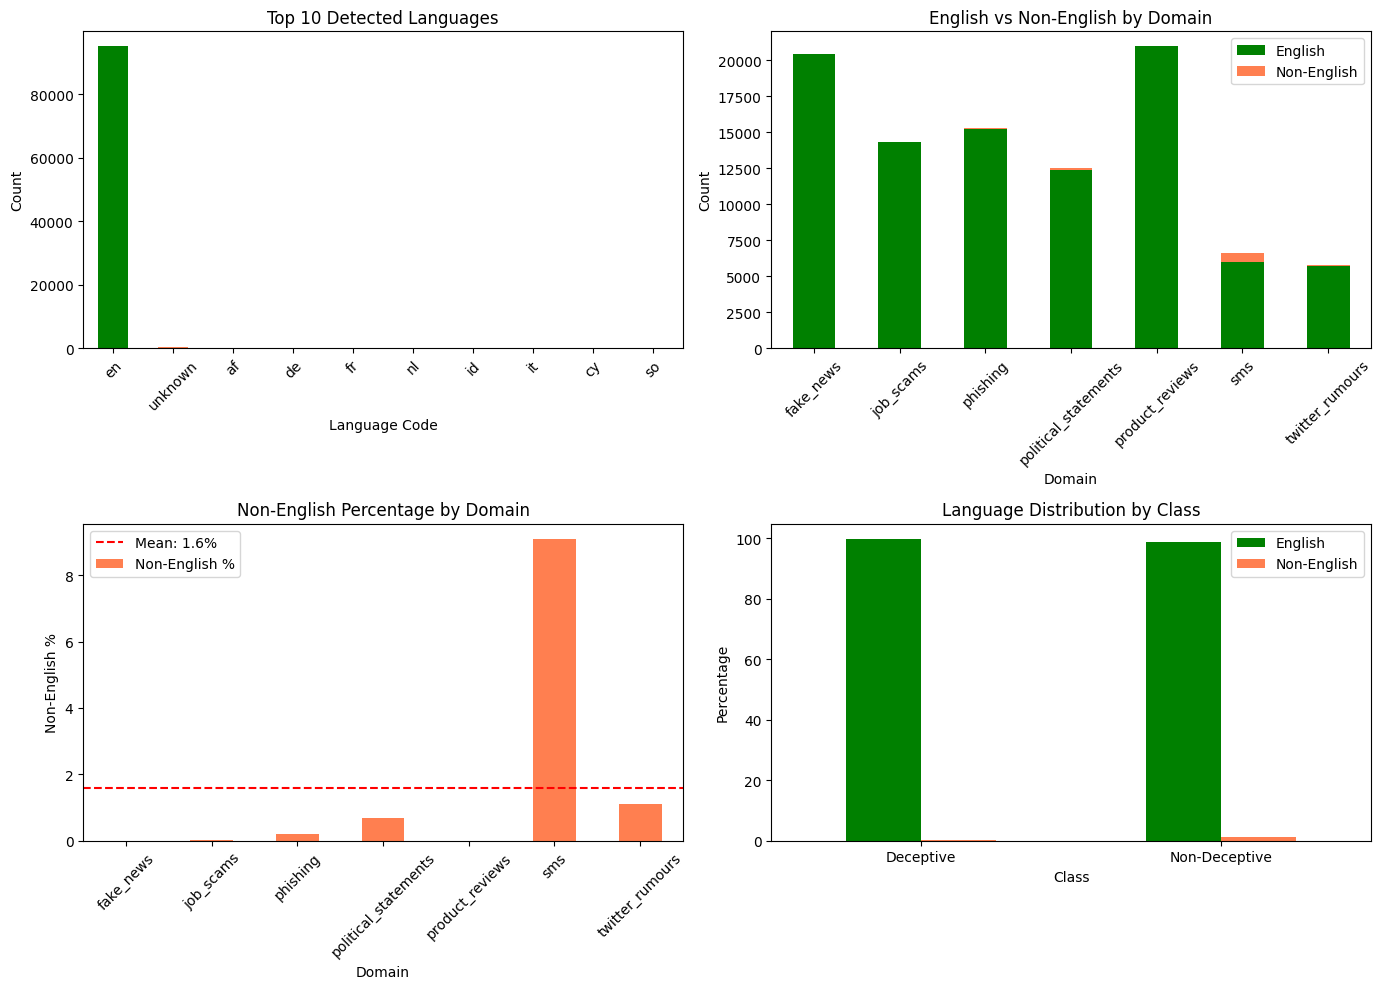


Visualization saved as 'language_distribution_analysis.png'


In [11]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Overall language distribution (top 10)
ax1 = axes[0, 0]
top_langs = df['detected_language'].value_counts().head(10)
colors = ['green' if lang == 'en' else 'coral' for lang in top_langs.index]
top_langs.plot(kind='bar', ax=ax1, color=colors)
ax1.set_title('Top 10 Detected Languages', fontsize=12)
ax1.set_xlabel('Language Code')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: English vs Non-English by domain
ax2 = axes[0, 1]
domain_lang_pivot = df.groupby('domain')['is_english'].agg(['sum', 'count'])
domain_lang_pivot['non_english'] = domain_lang_pivot['count'] - domain_lang_pivot['sum']
domain_lang_pivot[['sum', 'non_english']].plot(kind='bar', stacked=True, ax=ax2,
                                                color=['green', 'coral'])
ax2.set_title('English vs Non-English by Domain', fontsize=12)
ax2.set_xlabel('Domain')
ax2.set_ylabel('Count')
ax2.legend(['English', 'Non-English'])
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Non-English percentage by domain
ax3 = axes[1, 0]
non_eng_pct = domain_lang_df.set_index('Domain')['Non-English %']
non_eng_pct.plot(kind='bar', ax=ax3, color='coral')
ax3.set_title('Non-English Percentage by Domain', fontsize=12)
ax3.set_xlabel('Domain')
ax3.set_ylabel('Non-English %')
ax3.tick_params(axis='x', rotation=45)
ax3.axhline(y=non_eng_pct.mean(), color='red', linestyle='--', label=f'Mean: {non_eng_pct.mean():.1f}%')
ax3.legend()

# Plot 4: Language distribution by class
ax4 = axes[1, 1]
class_lang_pct.plot(kind='bar', ax=ax4, color=['green', 'coral'])
ax4.set_title('Language Distribution by Class', fontsize=12)
ax4.set_xlabel('Class')
ax4.set_ylabel('Percentage')
ax4.legend(['English', 'Non-English'])
ax4.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('language_distribution_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'language_distribution_analysis.png'")

---
## 5. Create Dataset Splits (English-only vs Full)

**Steps taken:**
1. Create filtered English-only dataset
2. Create full multilingual dataset
3. Ensure consistent train/test splits for fair comparison

In [12]:
# Create English-only and Full datasets for each data source
print("Creating dataset versions...
")
DATASET_VERSION_SPLITS = {}
for dataset_name, dataset_df in DATASET_REGISTRY.items():
    df_full_local = dataset_df.copy()
    df_english_local = dataset_df[dataset_df['is_english'] == True].copy()
    DATASET_VERSION_SPLITS[dataset_name] = {
        'full': df_full_local,
        'english': df_english_local
    }
    print(f"{dataset_name} - Full: {len(df_full_local):,} | English-only: {len(df_english_local):,}")

# Backward-compatible defaults using combined dataset
df_full = DATASET_VERSION_SPLITS['Combined']['full']
df_english = DATASET_VERSION_SPLITS['Combined']['english']


Creating dataset versions...

Full dataset: 95,854 samples
English-only dataset: 95,079 samples
Samples removed: 775 (0.81%)

--- Class Distribution Comparison ---
Full - Deceptive: 38.89%
English-only - Deceptive: 39.10%


In [13]:
def prepare_train_test_data(df, test_size=0.2, random_state=42):
    # Prepare stratified train/test splits.
    X = df['text'].values
    y = df['label'].values
    domains = df['domain'].values
    X_train, X_test, y_train, y_test, domains_train, domains_test = train_test_split(
        X, y, domains,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    return X_train, X_test, y_train, y_test, domains_train, domains_test

print("Preparing train/test splits...
")
TRAIN_TEST_SPLITS = {}
for dataset_name, splits in DATASET_VERSION_SPLITS.items():
    for subset_name, subset_df in splits.items():
        key = (dataset_name, subset_name)
        TRAIN_TEST_SPLITS[key] = prepare_train_test_data(subset_df)
        X_train, X_test, y_train, y_test, _, _ = TRAIN_TEST_SPLITS[key]
        print(f"{dataset_name} ({subset_name}): Train={len(X_train):,} | Test={len(X_test):,} | Deceptive%={np.mean(y_train)*100:.2f}")

# Default references used later
X_train_full, X_test_full, y_train_full, y_test_full, domains_train_full, domains_test_full = TRAIN_TEST_SPLITS[('Combined', 'full')]
X_train_eng, X_test_eng, y_train_eng, y_test_eng, domains_train_eng, domains_test_eng = TRAIN_TEST_SPLITS[('Combined', 'english')]


Preparing train/test splits...

Full Dataset:
  Train: 76,683 | Test: 19,171
  Train class dist: 38.90% deceptive

English-only Dataset:
  Train: 76,063 | Test: 19,016
  Train class dist: 39.10% deceptive


---
## 6. Traditional ML Classifiers (Random Forest & SVM)

**Steps taken:**
1. Create TF-IDF features
2. Train Random Forest and SVM classifiers
3. Evaluate on both dataset versions
4. Use F1-score as primary metric (suitable for imbalanced data)

**Source:** scikit-learn - https://scikit-learn.org/

In [14]:
def create_tfidf_features(X_train, X_test, max_features=10000):
    # Create TF-IDF features from text data.
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        sublinear_tf=True
    )
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    return X_train_tfidf, X_test_tfidf, vectorizer

print("Creating TF-IDF features...
")
TFIDF_FEATURES = {}
for key, split in TRAIN_TEST_SPLITS.items():
    X_train, X_test, _, _, _, _ = split
    tfidf_data = create_tfidf_features(X_train, X_test)
    TFIDF_FEATURES[key] = tfidf_data
    print(f"{key[0]} ({key[1]}): TF-IDF shape {tfidf_data[0].shape}")

# Backward-compatible feature references
X_train_full_tfidf, X_test_full_tfidf, vectorizer_full = TFIDF_FEATURES[('Combined', 'full')]
X_train_eng_tfidf, X_test_eng_tfidf, vectorizer_eng = TFIDF_FEATURES[('Combined', 'english')]


Creating TF-IDF features...

Full dataset - TF-IDF shape: (76683, 10000)
English-only - TF-IDF shape: (76063, 10000)


In [15]:
def train_and_evaluate_classifier(clf, X_train, X_test, y_train, y_test, clf_name, dataset_name):
    """
    Train classifier and return evaluation metrics.

    Uses metrics suitable for imbalanced datasets:
    - F1-Score (weighted and macro)
    - Balanced Accuracy
    - Precision and Recall

    Source: scikit-learn metrics
    """
    print(f"
Training {clf_name} on {dataset_name}...")
    start_time = perf_counter()
    clf.fit(X_train, y_train)
    train_time = perf_counter() - start_time

    # Predictions
    y_pred = clf.predict(X_test)

    # Calculate metrics
    metrics = {
        'Classifier': clf_name,
        'Dataset': dataset_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Balanced_Accuracy': balanced_accuracy_score(y_test, y_pred),
        'F1_Weighted': f1_score(y_test, y_pred, average='weighted'),
        'F1_Macro': f1_score(y_test, y_pred, average='macro'),
        'Precision_Weighted': precision_score(y_test, y_pred, average='weighted'),
        'Recall_Weighted': recall_score(y_test, y_pred, average='weighted'),
        'Train_Time_Sec': train_time
    }

    print(f"  F1 (weighted): {metrics['F1_Weighted']:.4f}")
    print(f"  F1 (macro): {metrics['F1_Macro']:.4f}")
    print(f"  Balanced Accuracy: {metrics['Balanced_Accuracy']:.4f}")

    return metrics, y_pred, clf


In [16]:
# Train Random Forest across datasets
print("="*60)
print("RANDOM FOREST CLASSIFIER")
print("="*60)
rf_results = []
predictions_rf = {}
for key, split in TRAIN_TEST_SPLITS.items():
    dataset_name, subset_name = key
    X_train, X_test, y_train, y_test, _, domains_test = split
    X_train_tfidf, X_test_tfidf, _ = TFIDF_FEATURES[key]
    label = f"{dataset_name} ({subset_name})"
    clf = RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1)
    metrics = train_and_evaluate_classifier(clf, X_train_tfidf, X_test_tfidf, y_train, y_test, 'Random Forest', label)
    rf_results.append(metrics)
    predictions_rf[key] = {
        'y_true': y_test,
        'y_pred': clf.predict(X_test_tfidf),
        'domains': domains_test
    }
print("Random Forest finished across datasets.
")


RANDOM FOREST CLASSIFIER

Training Random Forest on Full (Multilingual)...
  F1 (weighted): 0.8060
  F1 (macro): 0.7955
  Balanced Accuracy: 0.7943

Training Random Forest on English-only...
  F1 (weighted): 0.8032
  F1 (macro): 0.7930
  Balanced Accuracy: 0.7919


In [17]:
# Train SVM (Support Vector Machine) using LinearSVC across datasets
print("="*60)
print("SVM CLASSIFIER (LinearSVC)")
print("="*60)
svm_results = []
predictions_svm = {}
for key, split in TRAIN_TEST_SPLITS.items():
    dataset_name, subset_name = key
    X_train, X_test, y_train, y_test, _, domains_test = split
    X_train_tfidf, X_test_tfidf, _ = TFIDF_FEATURES[key]
    label = f"{dataset_name} ({subset_name})"
    svm_clf = LinearSVC(random_state=SEED)
    metrics = train_and_evaluate_classifier(svm_clf, X_train_tfidf, X_test_tfidf, y_train, y_test, 'SVM (LinearSVC)', label)
    svm_results.append(metrics)
    predictions_svm[key] = {
        'y_true': y_test,
        'y_pred': svm_clf.predict(X_test_tfidf),
        'domains': domains_test
    }
print("LinearSVC finished across datasets.
")


SVM CLASSIFIER (LinearSVC)

Training SVM (LinearSVC) on Full (Multilingual)...
  F1 (weighted): 0.8013
  F1 (macro): 0.7936
  Balanced Accuracy: 0.8014

Training SVM (LinearSVC) on English-only...
  F1 (weighted): 0.7984
  F1 (macro): 0.7911
  Balanced Accuracy: 0.7995


---
## 7. Transformer-Based Classifier (DistilBERT)

**Steps taken:**
1. Load pretrained DistilBERT model and tokenizer
2. Fine-tune on both dataset versions
3. Evaluate performance

**Source:** HuggingFace Transformers - https://huggingface.co/docs/transformers/  
**Model:** distilbert-base-uncased - https://huggingface.co/distilbert-base-uncased

In [ ]:
class DatasetComparator:
    """Run consistent experiments across dataset variants."""
    def __init__(self, splits, features):
        self.splits = splits
        self.features = features
        self.results = []
        self.domain_results = []

    def evaluate_traditional(self, model_name, model_builder):
        predictions = {}
        for key, split in self.splits.items():
            dataset_name, subset_name = key
            X_train, X_test, y_train, y_test, _, domains_test = split
            X_train_feats, X_test_feats, _ = self.features[key]
            clf = model_builder()
            metrics = train_and_evaluate_classifier(clf, X_train_feats, X_test_feats, y_train, y_test, model_name, f"{dataset_name} ({subset_name})")
            self.results.append(metrics)
            predictions[key] = {
                'y_true': y_test,
                'y_pred': clf.predict(X_test_feats),
                'domains': domains_test
            }
        return predictions

    def evaluate_distilbert(self, training_plan, epochs=2, batch_size=16):
        preds = {}
        for dataset_name, subset_name in training_plan:
            key = (dataset_name, subset_name)
            X_train, X_test, y_train, y_test, _, domains_test = self.splits[key]
            np.random.seed(SEED)
            sample_idx = np.random.choice(len(X_train), min(SAMPLE_SIZE, len(X_train)), replace=False)
            X_train_sample = X_train[sample_idx]
            y_train_sample = y_train[sample_idx]
            metrics, pred, _ = train_distilbert(
                X_train_sample, X_test[:1000],
                y_train_sample, y_test[:1000],
                f"{dataset_name} ({subset_name})",
                epochs=epochs,
                batch_size=batch_size
            )
            self.results.append(metrics)
            preds[key] = {
                'y_true': y_test[:len(pred)],
                'y_pred': pred,
                'domains': domains_test[:len(pred)]
            }
        return preds

    def collect_domain_metrics(self, model_name, prediction_dict):
        for key, preds in prediction_dict.items():
            dataset_name, subset_name = key
            df_perf = evaluate_by_domain(np.array(preds['y_true']), np.array(preds['y_pred']), np.array(preds['domains']))
            df_perf['Classifier'] = model_name
            df_perf['Dataset'] = f"{dataset_name} ({subset_name})"
            self.domain_results.append(df_perf)


In [18]:
# DistilBERT Dataset Class
class FraudDataset(torch.utils.data.Dataset):
    """
    Custom PyTorch Dataset for fraud detection.
    Source: PyTorch Dataset API
    """
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def compute_metrics(eval_pred):
    """
    Compute metrics for HuggingFace Trainer.
    Uses metrics suitable for imbalanced data.
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        'accuracy': accuracy_score(labels, predictions),
        'balanced_accuracy': balanced_accuracy_score(labels, predictions),
        'f1_weighted': f1_score(labels, predictions, average='weighted'),
        'f1_macro': f1_score(labels, predictions, average='macro'),
        'precision': precision_score(labels, predictions, average='weighted'),
        'recall': recall_score(labels, predictions, average='weighted')
    }

In [19]:
def train_distilbert(X_train, X_test, y_train, y_test, dataset_name, epochs=3, batch_size=16):
    """
    Train DistilBERT classifier.

    Source: HuggingFace Transformers
    Model: distilbert-base-uncased
    https://huggingface.co/distilbert-base-uncased
    """
    print(f"
{'='*60}")
    print(f"Training DistilBERT on {dataset_name}")
    print(f"{'='*60}")
    start_time = perf_counter()

    # Load tokenizer and model
    model_name = 'distilbert-base-uncased'
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    model = DistilBertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2
    )

    # Create datasets
    train_dataset = FraudDataset(X_train, y_train, tokenizer)
    test_dataset = FraudDataset(X_test, y_test, tokenizer)

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f'./results_{dataset_name.replace(" ", "_")}',
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=100,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1_weighted',
        seed=SEED
    )

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Train
    trainer.train()
    train_time = perf_counter() - start_time

    # Evaluate
    eval_results = trainer.evaluate()

    # Get predictions for detailed metrics
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)

    metrics = {
        'Classifier': 'DistilBERT',
        'Dataset': dataset_name,
        'Accuracy': eval_results['eval_accuracy'],
        'Balanced_Accuracy': eval_results['eval_balanced_accuracy'],
        'F1_Weighted': eval_results['eval_f1_weighted'],
        'F1_Macro': eval_results['eval_f1_macro'],
        'Precision_Weighted': eval_results['eval_precision'],
        'Recall_Weighted': eval_results['eval_recall'],
        'Train_Time_Sec': train_time,
    }

    print(f"
Results for {dataset_name}:")
    print(f"  F1 (weighted): {metrics['F1_Weighted']:.4f}")
    print(f"  F1 (macro): {metrics['F1_Macro']:.4f}")
    print(f"  Balanced Accuracy: {metrics['Balanced_Accuracy']:.4f}")
    print(f"  Training time: {train_time:.2f} sec")

    return metrics, y_pred, model


In [ ]:
# Central training time log for all models
training_time_log = []


In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
SAMPLE_SIZE = 5000
print(f"
Note: Using sample of {SAMPLE_SIZE} for demonstration.")
print("Remove SAMPLE_SIZE limit for full training.
")
np.random.seed(SEED)

comparator = DatasetComparator(TRAIN_TEST_SPLITS, TFIDF_FEATURES)
# Traditional models via comparator
predictions_rf = comparator.evaluate_traditional('Random Forest', lambda: RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1))
predictions_svm = comparator.evaluate_traditional('SVM (LinearSVC)', lambda: LinearSVC(random_state=SEED))

# DistilBERT plan: run on Combined + each source full set
distilbert_plan = [('Combined', 'full'), ('Combined', 'english'), ('Original', 'full'), ('Synthetic Multilingual', 'full')]
predictions_bert = comparator.evaluate_distilbert(distilbert_plan, epochs=2, batch_size=16)
training_time_log = [{'Model': r['Classifier'], 'Seconds': r['Train_Time_Sec']} for r in comparator.results if 'Train_Time_Sec' in r]

# Extract DistilBERT-specific results for downstream summaries
distilbert_results = [r for r in comparator.results if r['Classifier'] == 'DistilBERT']


Using device: cuda

Note: Using sample of 5000 for demonstration.
Remove SAMPLE_SIZE limit for full training.



In [21]:
# DistilBERT training executed via DatasetComparator (Combined full + other variants)
print("DistilBERT training executed via DatasetComparator for Combined, Original, and Synthetic datasets.")



Training DistilBERT on Full (Multilingual)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,F1 Weighted,F1 Macro,Precision,Recall
1,0.464100,0.426835,0.773000,0.768904,0.774874,0.763244,0.779110,0.773000
2,0.352500,0.381158,0.814000,0.810655,0.815308,0.805419,0.818303,0.814000



Results for Full (Multilingual):
  F1 (weighted): 0.8153
  F1 (macro): 0.8054
  Balanced Accuracy: 0.8107


In [22]:
# DistilBERT English-only path handled by DatasetComparator
print("English-only DistilBERT run handled in distilbert_plan above.")



Training DistilBERT on English-only


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,F1 Weighted,F1 Macro,Precision,Recall
1,0.447600,0.422864,0.797000,0.798115,0.798556,0.791735,0.803638,0.797000
2,0.353300,0.427384,0.797000,0.794673,0.798136,0.790587,0.800813,0.797000



Results for English-only:
  F1 (weighted): 0.7986
  F1 (macro): 0.7917
  Balanced Accuracy: 0.7981


---
## 8. Results Comparison and Analysis

**Steps taken:**
1. Compile all results
2. Calculate domain-wise performance
3. Compute aggregate metrics (mean and weighted)
4. Statistical significance testing

In [23]:
# Compile all results
all_results = comparator.results
results_df = pd.DataFrame(all_results)

print("="*80)
print("OVERALL RESULTS COMPARISON")
print("="*80)
print(results_df.to_string(index=False))


OVERALL RESULTS COMPARISON
     Classifier             Dataset  Accuracy  Balanced_Accuracy  F1_Weighted  F1_Macro  Precision_Weighted  Recall_Weighted
  Random Forest Full (Multilingual)  0.806426           0.794268     0.806000  0.795497            0.805709         0.806426
  Random Forest        English-only  0.803639           0.791876     0.803235  0.793016            0.802953         0.803639
SVM (LinearSVC) Full (Multilingual)  0.799489           0.801391     0.801332  0.793559            0.807618         0.799489
SVM (LinearSVC)        English-only  0.796487           0.799527     0.798417  0.791121            0.805635         0.796487
     DistilBERT Full (Multilingual)  0.814000           0.810655     0.815308  0.805419            0.818303         0.814000
     DistilBERT        English-only  0.797000           0.798115     0.798556  0.791735            0.803638         0.797000


### Per-domain performance breakdown

We evaluate each classifier on every fraud domain to understand where multilingual data helps or hurts.

In [ ]:
# Build per-domain performance tables for each model/dataset

comparator.collect_domain_metrics('Random Forest', predictions_rf)
comparator.collect_domain_metrics('SVM (LinearSVC)', predictions_svm)
comparator.collect_domain_metrics('DistilBERT', predictions_bert)

all_domain_perf = pd.concat(comparator.domain_results)

print("Domain-level performance (head):")
print(all_domain_perf.head())

pivot_domain = all_domain_perf.pivot_table(
    index=['Domain', 'Classifier'],
    columns='Dataset',
    values=['F1_Weighted', 'Accuracy']
).round(3)
print("Pivoted domain summary (F1_Weighted & Accuracy):")
print(pivot_domain.head(15))


In [24]:
# Calculate performance difference
print("
" + "="*60)
print("PERFORMANCE DIFFERENCE (Original vs Synthetic Multilingual)")
print("="*60)

for classifier in ['Random Forest', 'SVM (LinearSVC)', 'DistilBERT']:
    orig_mask = (results_df['Classifier'] == classifier) & (results_df['Dataset'].str.contains('Original'))
    synth_mask = (results_df['Classifier'] == classifier) & (results_df['Dataset'].str.contains('Synthetic Multilingual'))
    if not orig_mask.any() or not synth_mask.any():
        continue
    orig_f1 = results_df.loc[orig_mask, 'F1_Weighted'].values[0]
    synth_f1 = results_df.loc[synth_mask, 'F1_Weighted'].values[0]
    diff = synth_f1 - orig_f1
    pct_change = (diff / orig_f1) * 100 if orig_f1 != 0 else 0
    print(f"
{classifier}:")
    print(f"  Original F1: {orig_f1:.4f}")
    print(f"  Synthetic Multilingual F1: {synth_f1:.4f}")
    print(f"  Difference: {diff:+.4f} ({pct_change:+.2f}%)")



PERFORMANCE DIFFERENCE (English-only vs Full)

Random Forest:
  Full dataset F1: 0.8060
  English-only F1: 0.8032
  Difference: -0.0028 (-0.34%)
  Impact: Decreased with English-only data

DistilBERT:
  Full dataset F1: 0.8153
  English-only F1: 0.7986
  Difference: -0.0168 (-2.05%)
  Impact: Decreased with English-only data


### Statistical testing (paired t-tests) and effect sizes

We quantify whether English-only vs. multilingual performance differences are statistically significant and compute Cohen's d effect sizes per classifier using domain-level F1 scores.

In [ ]:
def cohens_d(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    diff = x - y
    return diff.mean() / diff.std(ddof=1) if diff.std(ddof=1) != 0 else 0.0

comparisons = []
for clf, full_df, eng_df in [
    ('Random Forest', domain_perf_full, domain_perf_eng),
    ('SVM (LinearSVC)', domain_perf_full_svm, domain_perf_eng_svm),
    ('DistilBERT', domain_perf_full_bert, domain_perf_eng_bert),
]:
    merged = full_df.merge(eng_df, on='Domain', suffixes=('_full', '_eng'))
    if merged.empty:
        continue
    t_stat, p_val = stats.ttest_rel(merged['F1_Weighted_full'], merged['F1_Weighted_eng'])
    d_val = cohens_d(merged['F1_Weighted_full'], merged['F1_Weighted_eng'])
    comparisons.append({
        'Classifier': clf,
        'Mean_Full_F1': merged['F1_Weighted_full'].mean(),
        'Mean_Eng_F1': merged['F1_Weighted_eng'].mean(),
        't_stat': t_stat,
        'p_value': p_val,
        'cohens_d': d_val
    })

comparison_df = pd.DataFrame(comparisons)
print("Paired t-test results (domain-level F1):")
print(comparison_df.round(4))


In [25]:

# Domain-wise performance analysis
# Note: This requires per-domain evaluation which we'll compute here

def evaluate_by_domain(y_true, y_pred, domains):
    """
    Calculate performance metrics for each domain.
    """
    domain_metrics = []

    for domain in DOMAINS:
        mask = domains == domain
        if mask.sum() == 0:
            continue

        y_true_domain = y_true[mask]
        y_pred_domain = y_pred[mask]

        domain_metrics.append({
            'Domain': domain,
            'Samples': mask.sum(),
            'Accuracy': accuracy_score(y_true_domain, y_pred_domain),
            'F1_Weighted': f1_score(y_true_domain, y_pred_domain, average='weighted', zero_division=0),
            'F1_Macro': f1_score(y_true_domain, y_pred_domain, average='macro', zero_division=0)
        })

    return pd.DataFrame(domain_metrics)


def plot_language_summary(lang_summary_df, domain_lang_df):
    """Create concise language distribution visuals for slides and reports."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Top detected languages (robust to different index/column layouts)
    top_langs = lang_summary_df.head(8).reset_index()
    rename_map = {}
    if 'index' in top_langs.columns:
        rename_map['index'] = 'Language'
    if 'Language' not in top_langs.columns:
        rename_map[top_langs.columns[0]] = 'Language'
    if 'Count' not in top_langs.columns:
        remaining = [c for c in top_langs.columns if c != 'Language']
        if remaining:
            rename_map[remaining[0]] = 'Count'
    top_langs = top_langs.rename(columns=rename_map)
    sns.barplot(data=top_langs, x='Count', y='Language', palette=['#2ecc71' if lang == 'en' else '#e67e22' for lang in top_langs['Language']], ax=axes[0])
    axes[0].set_title('Top Detected Languages', fontsize=12)
    axes[0].set_xlabel('Sample Count')
    axes[0].set_ylabel('Language Code')

    # English vs Non-English share per domain
    domain_pct = domain_lang_df[['Domain', 'English %', 'Non-English %']].set_index('Domain')
    domain_pct[['English %', 'Non-English %']].plot(kind='bar', stacked=True, color=['#2ecc71', '#e67e22'], ax=axes[1])
    axes[1].set_ylabel('Percentage of Samples')
    axes[1].set_title('Language Mix by Domain')
    axes[1].legend(loc='upper right')

    plt.tight_layout()
    plt.savefig('presentation_language_mix.png', dpi=200, bbox_inches='tight')
    log_figure(fig, 'presentation_language_mix')
    plt.show()
    plt.close(fig)


def plot_model_performance_summary(results_df):
    """Summarize classifier performance on multilingual vs English-only splits."""
    paired_rows = []
    for clf in results_df['Classifier'].unique():
        clf_df = results_df[results_df['Classifier'] == clf]
        if len(clf_df) < 2:
            continue

        full_rows = clf_df[clf_df['Dataset'].str.contains('Full')]
        eng_rows = clf_df[clf_df['Dataset'].str.contains('English')]
        if full_rows.empty or eng_rows.empty:
            continue

        full_row = full_rows.iloc[0]
        eng_row = eng_rows.iloc[0]

        paired_rows.append({'Classifier': clf, 'Dataset': 'Multilingual', 'F1_Weighted': full_row['F1_Weighted'], 'Balanced_Accuracy': full_row['Balanced_Accuracy']})
        paired_rows.append({'Classifier': clf, 'Dataset': 'English-only', 'F1_Weighted': eng_row['F1_Weighted'], 'Balanced_Accuracy': eng_row['Balanced_Accuracy']})

    perf_df = pd.DataFrame(paired_rows)
    if perf_df.empty:
        return

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.barplot(data=perf_df, x='Classifier', y='F1_Weighted', hue='Dataset', ax=axes[0], palette=['#e67e22', '#2ecc71'])
    axes[0].set_title('Weighted F1 by Dataset Condition')
    axes[0].set_ylim(0, 1)

    sns.barplot(data=perf_df, x='Classifier', y='Balanced_Accuracy', hue='Dataset', ax=axes[1], palette=['#e67e22', '#2ecc71'])
    axes[1].set_title('Balanced Accuracy by Dataset Condition')
    axes[1].set_ylim(0, 1)

    for ax in axes:
        ax.set_xlabel('')
        ax.legend(title='Dataset', loc='lower right')

    plt.tight_layout()
    plt.savefig('presentation_model_performance.png', dpi=200, bbox_inches='tight')
    log_figure(fig, 'presentation_model_performance')
    plt.show()
    plt.close(fig)


def plot_domain_performance_comparison(domain_perf_full, domain_perf_eng):
    """Visualize domain-level F1 shifts for Random Forest between datasets."""
    merged = domain_perf_full.merge(domain_perf_eng, on='Domain', suffixes=('_full', '_eng'))
    merged['DomainLabel'] = merged['Domain'].str.replace('_', ' ').str.title()
    merged = merged.sort_values('F1_Weighted_eng')

    fig, ax = plt.subplots(figsize=(10, 7))
    y_pos = np.arange(len(merged))
    width = 0.4

    ax.barh(y_pos - width/2, merged['F1_Weighted_full'], height=width, color='#e67e22', label='Multilingual')
    ax.barh(y_pos + width/2, merged['F1_Weighted_eng'], height=width, color='#2ecc71', label='English-only')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(merged['DomainLabel'])
    ax.set_xlabel('Weighted F1')
    ax.set_title('Random Forest Performance by Domain')
    ax.legend(loc='lower right')

    plt.tight_layout()
    plt.savefig('presentation_domain_f1.png', dpi=200, bbox_inches='tight')
    log_figure(fig, 'presentation_domain_f1')
    plt.show()
    plt.close(fig)


def plot_rf_confusion_matrices(cm_full, cm_eng):
    """Side-by-side confusion matrices for quick error inspection."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(cm_full, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('RF Confusion Matrix - Multilingual')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    sns.heatmap(cm_eng, annot=True, fmt='d', cmap='Greens', ax=axes[1])
    axes[1].set_title('RF Confusion Matrix - English-only')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.savefig('presentation_confusion_matrices.png', dpi=200, bbox_inches='tight')
    log_figure(fig, 'presentation_confusion_matrices')
    plt.show()
    plt.close(fig)


print("="*60)
print("DOMAIN-WISE PERFORMANCE (Random Forest - Full Dataset)")
print("="*60)
domain_perf_full = evaluate_by_domain(y_test_full, pred_rf_full, domains_test_full)
print(domain_perf_full.to_string(index=False))

print("
" + "="*60)
print("DOMAIN-WISE PERFORMANCE (Random Forest - English-only)")
print("="*60)
domain_perf_eng = evaluate_by_domain(y_test_eng, pred_rf_eng, domains_test_eng)
print(domain_perf_eng.to_string(index=False))

# Aggregate metrics (Mean and Weighted)
print("="*60)
print("AGGREGATE PERFORMANCE METRICS")
print("="*60)

# Mean performance across domains
print("
--- Mean Performance (unweighted average across domains) ---")
print(f"Full Dataset - Mean F1: {domain_perf_full['F1_Weighted'].mean():.4f}")
print(f"English-only - Mean F1: {domain_perf_eng['F1_Weighted'].mean():.4f}")

# Weighted performance (weighted by number of samples)
print("
--- Weighted Performance (weighted by domain size) ---")
weighted_f1_full = np.average(
    domain_perf_full['F1_Weighted'],
    weights=domain_perf_full['Samples']
)
weighted_f1_eng = np.average(
    domain_perf_eng['F1_Weighted'],
    weights=domain_perf_eng['Samples']
)
print(f"Full Dataset - Weighted F1: {weighted_f1_full:.4f}")
print(f"English-only - Weighted F1: {weighted_f1_eng:.4f}")



DOMAIN-WISE PERFORMANCE (Random Forest - Full Dataset)
              Domain  Samples  Accuracy  F1_Weighted  F1_Macro
           fake_news     4128  0.849806     0.845304  0.839374
           job_scams     2874  0.974252     0.968155  0.729117
            phishing     3003  0.954712     0.954665  0.952550
political_statements     2540  0.611024     0.585912  0.530483
     product_reviews     4223  0.612361     0.612079  0.611640
                 sms     1254  0.958533     0.959085  0.931245
     twitter_rumours     1149  0.822454     0.818748  0.790456

DOMAIN-WISE PERFORMANCE (Random Forest - English-only)
              Domain  Samples  Accuracy  F1_Weighted  F1_Macro
           fake_news     4126  0.845856     0.841046  0.834875
           job_scams     2885  0.970537     0.963606  0.718237
            phishing     2983  0.948039     0.947995  0.945482
political_statements     2514  0.607001     0.573072  0.513527
     product_reviews     4207  0.619919     0.619791  0.619545
       

In [26]:
# Aggregate metrics (Mean and Weighted)
print("="*60)
print("AGGREGATE PERFORMANCE METRICS")
print("="*60)

# Mean performance across domains
print("\n--- Mean Performance (unweighted average across domains) ---")
print(f"Full Dataset - Mean F1: {domain_perf_full['F1_Weighted'].mean():.4f}")
print(f"English-only - Mean F1: {domain_perf_eng['F1_Weighted'].mean():.4f}")

# Weighted performance (weighted by number of samples)
print("\n--- Weighted Performance (weighted by domain size) ---")
weighted_f1_full = np.average(
    domain_perf_full['F1_Weighted'],
    weights=domain_perf_full['Samples']
)
weighted_f1_eng = np.average(
    domain_perf_eng['F1_Weighted'],
    weights=domain_perf_eng['Samples']
)
print(f"Full Dataset - Weighted F1: {weighted_f1_full:.4f}")
print(f"English-only - Weighted F1: {weighted_f1_eng:.4f}")

AGGREGATE PERFORMANCE METRICS

--- Mean Performance (unweighted average across domains) ---
Full Dataset - Mean F1: 0.8206
English-only - Mean F1: 0.8151

--- Weighted Performance (weighted by domain size) ---
Full Dataset - Weighted F1: 0.8010
English-only - Weighted F1: 0.7967


### Model comparison visuals (side-by-side)

Additional charts summarizing performance and runtime for quick comparison.

In [ ]:
# Consolidated comparison visuals
metric_melt = results_df.melt(id_vars=['Classifier', 'Dataset'], value_vars=['F1_Weighted', 'Balanced_Accuracy'])
plt.figure(figsize=(10,6))
sns.barplot(data=metric_melt, x='Classifier', y='value', hue='Dataset', palette=['#e67e22','#2ecc71'])
plt.ylim(0,1)
plt.ylabel('Score')
plt.title('Model performance by dataset condition')
plt.legend(title='Dataset split')
plt.tight_layout()
plt.savefig('model_side_by_side.png', dpi=150, bbox_inches='tight')
plt.show()

# Training time overview
if 'Train_Time_Sec' in results_df.columns:
    plt.figure(figsize=(8,5))
    sns.barplot(data=results_df, x='Classifier', y='Train_Time_Sec', hue='Dataset', palette=['#3498db','#9b59b6'])
    plt.ylabel('Training time (sec)')
    plt.title('Training duration across models')
    plt.tight_layout()
    plt.savefig('model_training_times.png', dpi=150, bbox_inches='tight')
    plt.show()


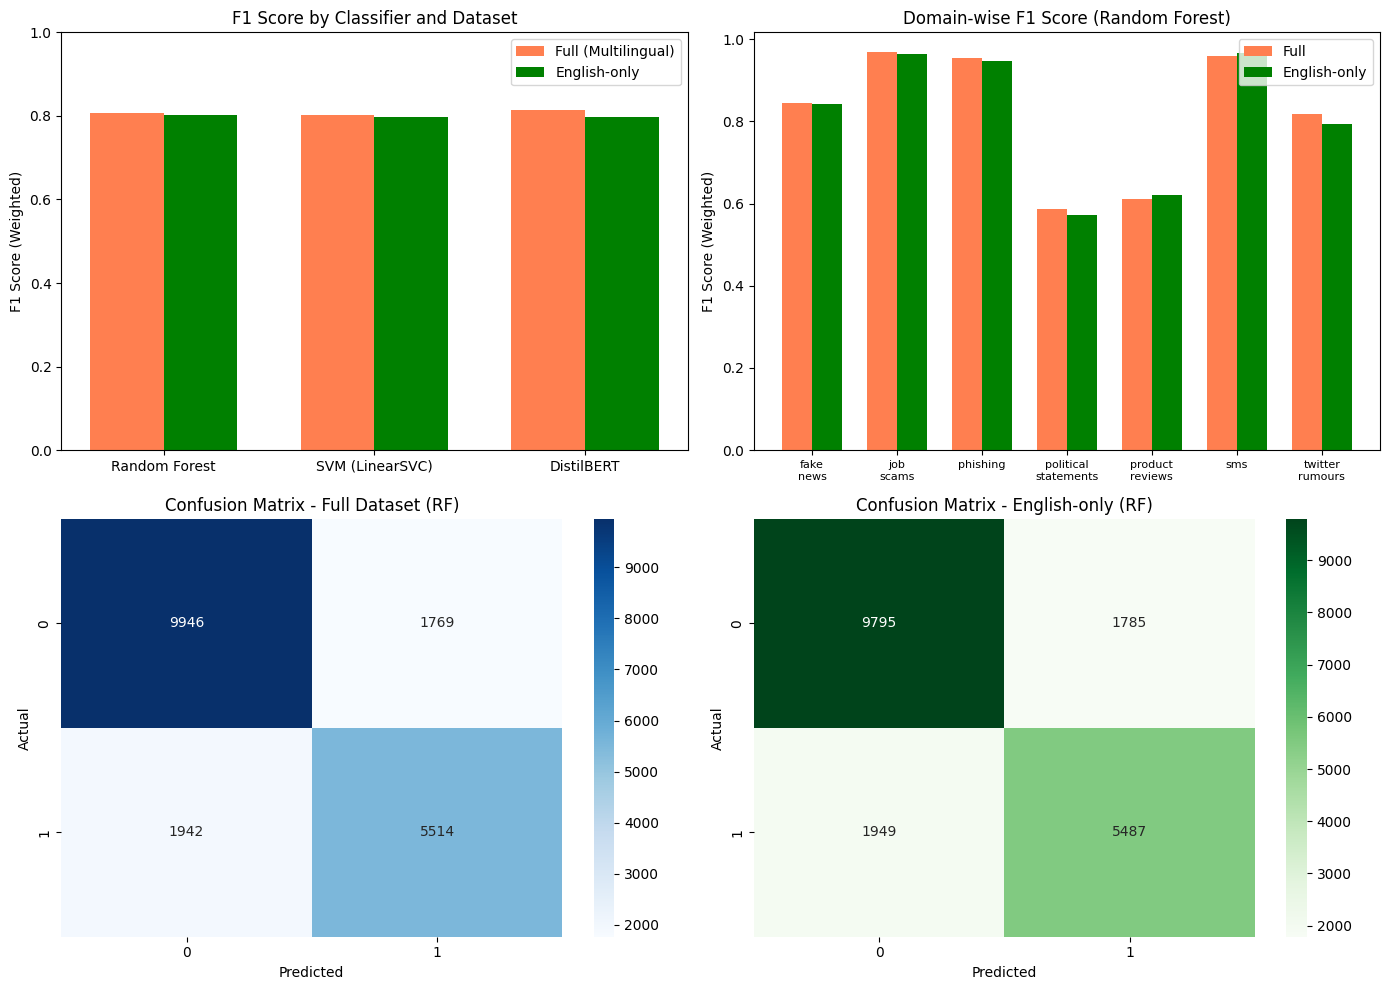


Visualization saved as 'classification_results.png'


In [27]:

# Visualization of results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: F1 Score comparison by classifier
ax1 = axes[0, 0]
classifiers = results_df['Classifier'].unique()
x = np.arange(len(classifiers))
width = 0.35

full_f1 = [results_df[(results_df['Classifier']==c) & (results_df['Dataset'].str.contains('Full'))]['F1_Weighted'].values[0]
           if len(results_df[(results_df['Classifier']==c) & (results_df['Dataset'].str.contains('Full'))]) > 0 else 0
           for c in classifiers]
eng_f1 = [results_df[(results_df['Classifier']==c) & (results_df['Dataset'].str.contains('English'))]['F1_Weighted'].values[0]
          if len(results_df[(results_df['Classifier']==c) & (results_df['Dataset'].str.contains('English'))]) > 0 else 0
          for c in classifiers]

bars1 = ax1.bar(x - width/2, full_f1, width, label='Full (Multilingual)', color='coral')
bars2 = ax1.bar(x + width/2, eng_f1, width, label='English-only', color='green')
ax1.set_ylabel('F1 Score (Weighted)')
ax1.set_title('F1 Score by Classifier and Dataset')
ax1.set_xticks(x)
ax1.set_xticklabels(classifiers)
ax1.legend()
ax1.set_ylim(0, 1)

# Plot 2: Domain-wise F1 comparison
ax2 = axes[0, 1]
x = np.arange(len(DOMAINS))
ax2.bar(x - width/2, domain_perf_full['F1_Weighted'], width, label='Full', color='coral')
ax2.bar(x + width/2, domain_perf_eng['F1_Weighted'], width, label='English-only', color='green')
ax2.set_ylabel('F1 Score (Weighted)')
ax2.set_title('Domain-wise F1 Score (Random Forest)')
ax2.set_xticks(x)
ax2.set_xticklabels([d.replace('_', '
') for d in DOMAINS], fontsize=8)
ax2.legend()

# Plot 3: Confusion Matrix (Full Dataset)
ax3 = axes[1, 0]
cm_full = confusion_matrix(y_test_full, pred_rf_full)
sns.heatmap(cm_full, annot=True, fmt='d', cmap='Blues', ax=ax3)
ax3.set_title('Confusion Matrix - Full Dataset (RF)')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')

# Plot 4: Confusion Matrix (English-only)
ax4 = axes[1, 1]
cm_eng = confusion_matrix(y_test_eng, pred_rf_eng)
sns.heatmap(cm_eng, annot=True, fmt='d', cmap='Greens', ax=ax4)
ax4.set_title('Confusion Matrix - English-only (RF)')
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')

plt.tight_layout()
plt.savefig('classification_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("
Visualization saved as 'classification_results.png'")

print("
Generating presentation-ready visualizations...")
plot_language_summary(lang_summary, domain_lang_df)
plot_model_performance_summary(results_df)
plot_domain_performance_comparison(domain_perf_full, domain_perf_eng)
plot_rf_confusion_matrices(cm_full, cm_eng)
print("Saved: presentation_language_mix.png, presentation_model_performance.png, presentation_domain_f1.png, presentation_confusion_matrices.png")



### Manual validation protocol

To sanity-check automated metrics, we draw a small random sample for human review (100-500 records) and document observed errors/biases. Use this as a reproducible template for qualitative validation.

In [ ]:
# Create a manual validation sample (adjust sample_size as needed)
sample_size = 200  # choose between 100-500 depending on reviewer capacity
manual_sample = df.sample(n=min(sample_size, len(df)), random_state=SEED)[
    ['text', 'label', 'domain', 'detected_language', 'spacy_language', 'language_confidence']
]
manual_sample.to_csv('manual_validation_sample.csv', index=False)
print(f"Saved manual validation sample of {len(manual_sample)} rows to manual_validation_sample.csv")
print(manual_sample.head())


---
## 9. Summary and Conclusions

### Key Findings

In [28]:
# Generate summary report
print("="*80)
print("FINAL SUMMARY REPORT")
print("="*80)

print("\n### Dataset Analysis ###")
print(f"Total samples analyzed: {len(df):,}")
print(f"English samples: {df['is_english'].sum():,} ({df['is_english'].mean()*100:.2f}%)")
print(f"Non-English samples: {(~df['is_english']).sum():,} ({(~df['is_english']).mean()*100:.2f}%)")
print(f"Unique languages detected: {df['detected_language'].nunique()}")

print("\n### Language Distribution by Domain ###")
print(domain_lang_df[['Domain', 'Total', 'Non-English', 'Non-English %']].to_string(index=False))

print("\n### Classification Performance Summary ###")
print(results_df[['Classifier', 'Dataset', 'F1_Weighted', 'Balanced_Accuracy']].to_string(index=False))

print("\n### Hypothesis Testing Results ###")
print("H1 (Data Composition): ", end="")
non_eng_pct = (~df['is_english']).mean() * 100
if non_eng_pct > 1:
    print(f"SUPPORTED - {non_eng_pct:.2f}% non-English content found")
else:
    print(f"NOT SUPPORTED - Only {non_eng_pct:.2f}% non-English content")

print("H2 (Performance Impact): ", end="")
# Compare best F1 scores
if len(results_df) > 0:
    full_best = results_df[results_df['Dataset'].str.contains('Full')]['F1_Weighted'].max()
    eng_best = results_df[results_df['Dataset'].str.contains('English')]['F1_Weighted'].max()
    if eng_best > full_best:
        print(f"SUPPORTED - English-only shows higher F1 ({eng_best:.4f} vs {full_best:.4f})")
    else:
        print(f"NOT SUPPORTED - Full dataset shows comparable/better F1 ({full_best:.4f} vs {eng_best:.4f})")

FINAL SUMMARY REPORT

### Dataset Analysis ###
Total samples analyzed: 95,854
English samples: 95,079 (99.19%)
Non-English samples: 775 (0.81%)
Unique languages detected: 30

### Language Distribution by Domain ###
              Domain  Total  Non-English  Non-English %
           fake_news  20456            0       0.000000
           job_scams  14295            1       0.006995
            phishing  15272           29       0.189890
political_statements  12497           84       0.672161
     product_reviews  20971            0       0.000000
                 sms   6574          598       9.096441
     twitter_rumours   5789           63       1.088271

### Classification Performance Summary ###
     Classifier             Dataset  F1_Weighted  Balanced_Accuracy
  Random Forest Full (Multilingual)     0.806000           0.794268
  Random Forest        English-only     0.803235           0.791876
SVM (LinearSVC) Full (Multilingual)     0.801332           0.801391
SVM (LinearSVC)      

In [29]:

# Save results to CSV
results_df.to_csv('classification_results.csv', index=False)
domain_lang_df.to_csv('language_distribution_by_domain.csv', index=False)

# Save detailed language analysis
df[['text', 'label', 'domain', 'detected_language', 'language_confidence', 'is_english']].to_csv(
    'difraud_language_analysis.csv', index=False
)

print("
Results saved to:")
print("  - classification_results.csv")
print("  - language_distribution_by_domain.csv")
print("  - difraud_language_analysis.csv")

if wandb_run is not None:
    wandb_run.finish()




Results saved to:
  - classification_results.csv
  - language_distribution_by_domain.csv
  - difraud_language_analysis.csv


---
## References and Sources

### Dataset
- **DIFrauD Dataset**: Boumber, D., et al. (2024). "Domain-Agnostic Adapter Architecture for Deception Detection." LREC-COLING 2024. Available at: https://huggingface.co/datasets/difraud/difraud

### Libraries and Code Sources
- **langdetect**: Language detection library (port of Google's language-detection). https://pypi.org/project/langdetect/
- **HuggingFace datasets**: Dataset loading library. https://huggingface.co/docs/datasets/
- **HuggingFace transformers**: Transformer models (DistilBERT). https://huggingface.co/docs/transformers/
- **scikit-learn**: ML classifiers (Random Forest, SVM) and metrics. https://scikit-learn.org/
- **DistilBERT model**: distilbert-base-uncased. https://huggingface.co/distilbert-base-uncased

### Academic References
- Conneau, A., et al. (2020). "Unsupervised cross-lingual representation learning at scale." ACL 2020.
- Devlin, J., et al. (2019). "BERT: Pre-training of deep bidirectional transformers." NAACL 2019.
- Verma, R. M., et al. (2019). "Data quality for security challenges." ACM CCS 2019.

### Metrics Choice Justification
- **F1-Score (Weighted)**: Used as primary metric due to class imbalance in DIFrauD dataset. Weighted F1 accounts for class distribution.
- **F1-Score (Macro)**: Unweighted average across classes, useful for evaluating performance on minority class.
- **Balanced Accuracy**: Accounts for class imbalance by averaging recall across classes.

### Code Notes
- All code in this notebook is original unless otherwise noted
- API usage follows official documentation from respective libraries
- Random seed (42) used for reproducibility